# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [50]:
import numpy as np
import pandas as pd

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = -0.1574669194221497
secret_number = int_to_float(float_to_int(secret_number))
print('secret_number =', secret_number)

secret_number = -0.15746691823005676


In [76]:
def get_mask(component, mantissa_byte_index=None):
    if component == 'mantissa':
        assert((mantissa_byte_index is not None) and ((mantissa_byte_index >= 0) and (mantissa_byte_index < 3)))
        nbits = sum(AdvancedWeightRecovery.MANTISSA_THREE_BYTES[:mantissa_byte_index])
        mask = ((1 << nbits) - 1) << (AdvancedWeightRecovery.MAX_MANTISSA_NBITS - nbits)
    elif component == 'exponent':
        mask = (1 << AdvancedWeightRecovery.MAX_MANTISSA_NBITS) - 1
    return mask

In [62]:
number_of_best_candidates = 30
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=number_of_best_candidates)

## ONE STEP

In [53]:
%%time
secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]    
s = awr.recover_weight(secret_hamming_weight_set)
s

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../pybatina/advanced_weight_recovery.py:208: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:208: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 7.72 s, sys: 184 ms, total: 7.9 s
Wall time: 7.9 s


-0.157467    1.000000
-0.157467    0.894827
-0.157467    0.877266
-0.155767    0.846197
-0.155767    0.761540
-0.155767    0.737945
-0.126217    0.730317
-0.157467    0.523962
-0.157467    0.512802
-0.157467    0.425329
dtype: float64

In [54]:
x = secret_number
print('{:032b}'.format(float_to_int(x)), x)

idx = 2
x = s.index[idx]
print('{:032b}'.format(float_to_int(x)), x, s.iloc[idx])

10111110001000010011111100000010 -0.15746691823005676
10111110001000010011111100000011 -0.15746693313121796 0.877265543944322


## STEP-BY-STEP

### Correlation of mantissa

In [79]:
%%time

numbers = None
mantissa_correlations = {}
known_inputs = awr.build_input_values(component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
# for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):    
#     if numbers is not None:
#         mantissa_corr = pd.Series()
#         for number in numbers:
#             guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=np.asarray([number]))
#             corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False)
#             mantissa_corr = pd.concat([mantissa_corr, corr.iloc[:3]])
#     else:
#         guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=None)
#         mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

#     mantissa_corr.sort_values(ascending=False, inplace=True)
#     numbers = mantissa_corr.index[:awr.number_of_best_candidates]
#     mantissa_correlations[mantissa_byte_index] = mantissa_corr

for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):    
    guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=numbers)
    mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers)
    if numbers is not None:
        print((np.vectorize(float_to_int)(guess_numbers) & mask) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))

    mantissa_corr.sort_values(ascending=False, inplace=True)
    numbers = mantissa_corr.index[:awr.number_of_best_candidates]
    mantissa_correlations[mantissa_byte_index] = mantissa_corr


[1065353216 1065353472 1065353728 ... 1073544448 1073544704 1073544960]
[1065434880 1065434880 1065434880 ... 1067536384 1067536384 1067536384]
CPU times: user 19.7 s, sys: 484 ms, total: 20.2 s
Wall time: 20.2 s


00111110001000010011111100000010 0.15746691823005676 ----------
00111111101000010000000000000000 1.2578125 0.1443640075489305
00111110001000010011111100000010 0.15746691823005676 ----------
00111111101000010011111100000000 1.259735107421875 0.4417744936918859
00111110001000010011111100000010 0.15746691823005676 ----------
00111111101000010011111100000010 1.259735345840454 0.5603546036289869


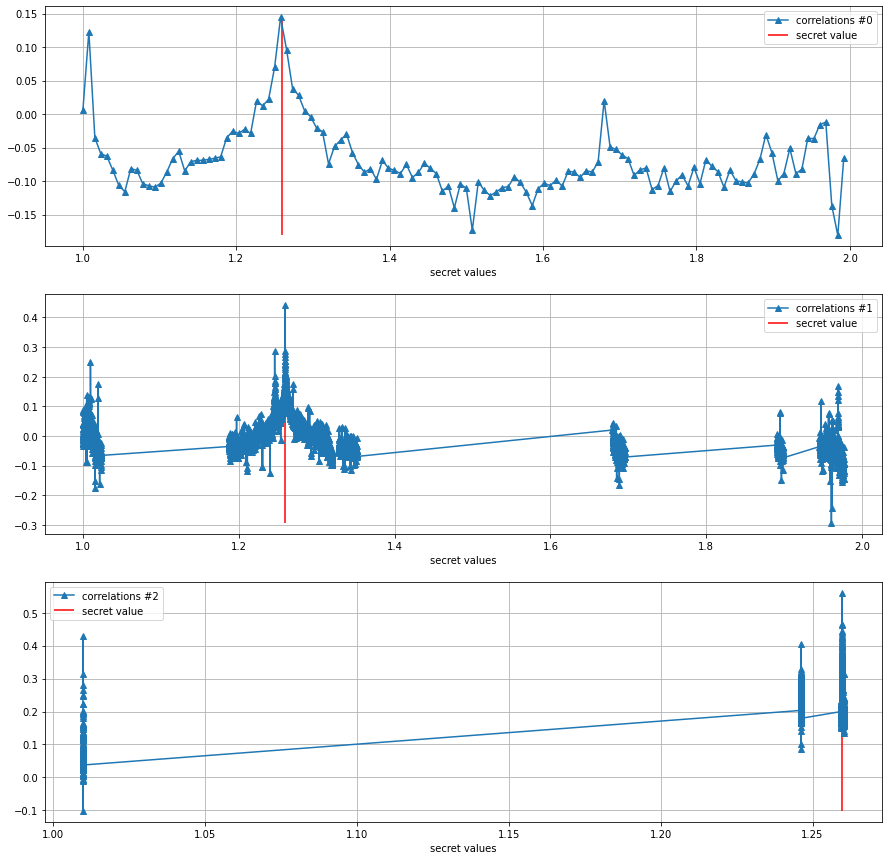

In [78]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx, kind='line', marker='^')
    x = int_to_float((float_to_int(abs(secret_number)) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')
    
    x = abs(secret_number)
    print('{:032b}'.format(float_to_int(x)), x, '-' * 10)
    x = mantissa_correlations[idx].index[0]
    print('{:032b}'.format(float_to_int(x)), x, mantissa_correlations[idx].iloc[0])

In [68]:
mantissa_correlations[2].iloc[:20]

1.259735    0.560355
1.259735    0.465198
1.259735    0.463254
1.259736    0.445029
1.259735    0.441774
1.259735    0.434118
1.009735    0.430218
1.259736    0.428426
1.259735    0.425026
1.259736    0.424978
1.259842    0.423602
1.259735    0.418917
1.259736    0.413262
1.259735    0.412810
1.259736    0.407697
1.259842    0.407392
1.246132    0.406641
1.259735    0.402907
1.259736    0.402697
1.259736    0.402257
dtype: float64

In [58]:
numbers=np.asarray(mantissa_corr.index[:awr.number_of_best_candidates])
numbers

array([1.25973535, 1.25973547, 1.25973523, 1.25973558, 1.25973511,
       1.25973499, 1.00973535, 1.2597357 , 1.25973487, 1.25973582])

# sign

In [11]:
positive_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=numbers)
negative_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=-numbers)

In [12]:
corr = positive_corr
if positive_corr.sum() < negative_corr.sum():
    numbers = -numbers
    corr = negative_corr
numbers

array([-1.37493384, -1.37493396, -1.37493372, -1.37496686, -1.37496698,
       -1.37496674, -1.37506092, -1.37504184, -1.37567139, -1.37504196,
       -1.3750838 , -1.37506104, -1.37508392, -1.37567151, -1.37460339,
       -1.37567163, -1.37460327, -1.37460363, -1.9661864 , -1.50268555,
       -1.84408569, -1.38574302, -1.50067139, -1.84442139, -1.9661597 ,
       -1.50268567, -1.50268579, -1.38348389, -1.50033569, -1.38574255])

Text(0.5, 0, 'secret values')

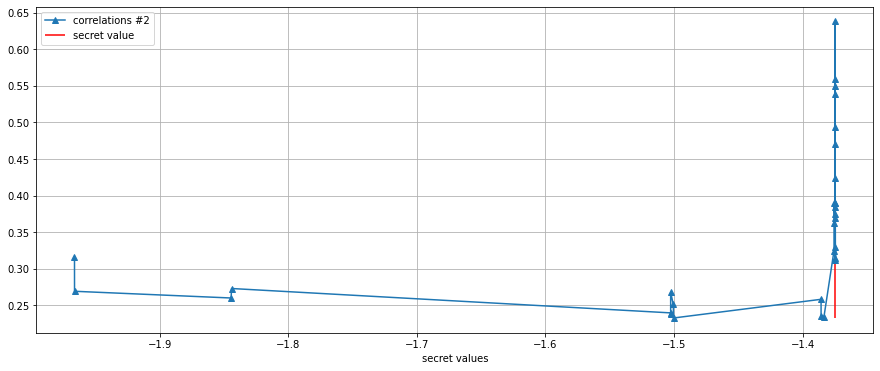

In [13]:
from matplotlib import pyplot as plt
ax = corr.sort_index().plot(label='correlations #%d' % idx, figsize=(15,6), marker='^')
x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
ax.vlines(x, corr.min(), corr.max(), color='red', label='secret value')
ax.legend()
ax.grid(True)
ax.set_xlabel('secret values')

### Correlation exponent

In [14]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

mantisa_exp_corr = pd.Series()
for number in numbers:
    guess_numbers = AdvancedWeightRecovery.build_guess_values(component='exponent', numbers=np.asarray([number]))
    guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
    corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False).iloc[:awr.number_of_best_candidates]
    mantisa_exp_corr = pd.concat([mantisa_exp_corr, corr.iloc[:3]])
# get the best values
mantisa_exp_corr.sort_values(ascending=False, inplace=True)
numbers = np.asarray(mantisa_exp_corr.index[:awr.number_of_best_candidates])

<timed exec>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
<timed exec>:7: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:7: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1.65 s, sys: 20 ms, total: 1.67 s
Wall time: 1.67 s


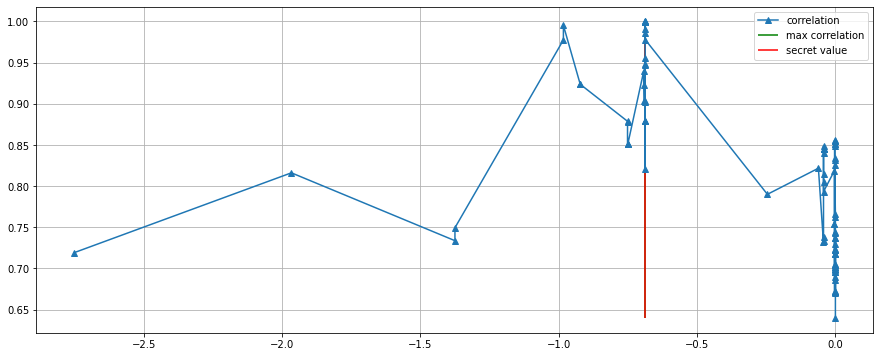

In [15]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [16]:
mantisa_exp_corr.iloc[:awr.number_of_best_candidates]

-0.687467    1.000000
-0.687483    1.000000
-0.687483    0.999591
-0.687483    0.999572
-0.687467    0.999572
-0.687467    0.999193
-0.983080    0.995274
-0.687302    0.991219
-0.687302    0.985455
-0.687302    0.977908
-0.983093    0.977560
-0.687542    0.955788
-0.687521    0.947851
-0.687530    0.947646
-0.692872    0.939452
-0.922043    0.923646
-0.922211    0.923646
-0.692871    0.923320
-0.691742    0.902843
-0.687836    0.902843
-0.687836    0.902516
-0.687521    0.878757
-0.687836    0.878757
-0.687542    0.878757
-0.751343    0.878757
-0.751343    0.878462
-0.002685    0.855877
-0.002685    0.854741
-0.002685    0.854420
-0.002685    0.851677
dtype: float64

### Last sorting

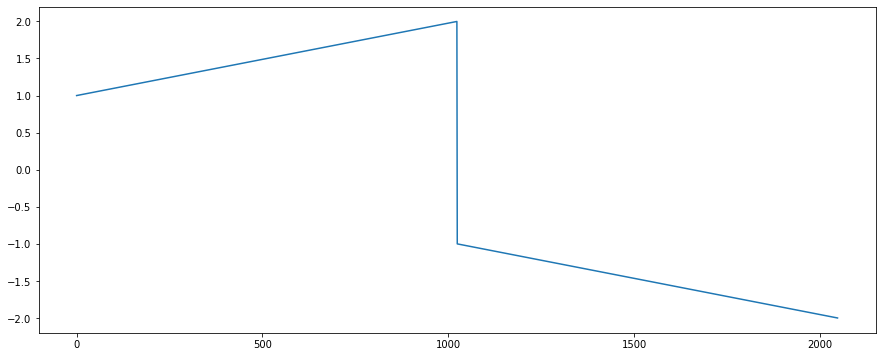

In [17]:
# known_inputs = np.concatenate((awr.build_input_values(component='mantissa'), awr.build_input_values(component='exponent')))
# known_inputs = np.random.uniform(-1, 1, 1000)
known_inputs = awr.build_input_values(component='mantissa')
#known_inputs = awr.build_input_values(component='exponent')

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
full_corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, numbers).sort_values(ascending=False)
pd.Series(known_inputs).plot(figsize=(15, 6))

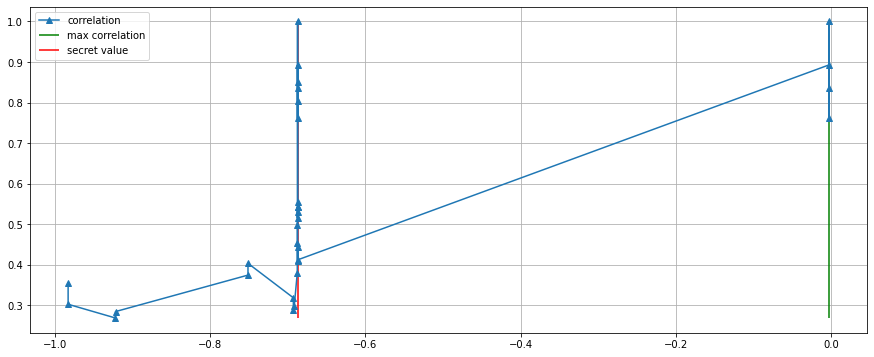

In [18]:
ax = full_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(full_corr.idxmax(), full_corr.min(), full_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, full_corr.min(), full_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [19]:
full_corr.iloc[:awr.number_of_best_candidates].mean()

0.5602776184484809

### Result

In [23]:
x = secret_number
print('{:032b}'.format(float_to_int(x)), x)

idx = 0
x = full_corr.index[idx]
print('{:032b}'.format(float_to_int(x)), x, full_corr.iloc[idx])

10111111001011111111110111010101 -0.6874669194221497
10111011001011111111110111010101 -0.002685417653992772 1.0


In [21]:
print('secret_number:', secret_number)
print('the best guessed value:', full_corr.index[0], 'Correlation:', full_corr.iloc[0])

secret_number: -0.6874669194221497
the best guessed value: -0.002685417653992772 Correlation: 1.0


In [22]:
full_corr

-0.002685    1.000000
-0.687467    1.000000
-0.002685    0.892844
-0.687483    0.892844
-0.687467    0.850712
-0.687467    0.835054
-0.002685    0.835054
-0.687483    0.803016
-0.002685    0.760772
-0.687483    0.760772
-0.687521    0.555636
-0.687542    0.543203
-0.687521    0.542452
-0.687542    0.528889
-0.687530    0.515660
-0.687836    0.498929
-0.687836    0.454154
-0.687302    0.444176
-0.687302    0.411987
-0.687302    0.410397
-0.751343    0.403446
-0.687836    0.379861
-0.751343    0.374385
-0.983093    0.353978
-0.692872    0.318364
-0.983080    0.302436
-0.691742    0.297688
-0.692871    0.288578
-0.922043    0.284408
-0.922211    0.268632
dtype: float64